Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [6]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

### Importing Skin Cancer Data from my google drive 

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:

# path where the dataset is located on my drive
root_path = '/content/gdrive/My Drive/Upgrad/C3 Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration'


# below code is for unziping the zipped dataset
#!unzip -q '/content/gdrive/My Drive/Upgrad/C3 Melanoma Assignment/CNN_assignment.zip' -d '/content/gdrive/My Drive/Upgrad/C3 Melanoma Assignment' 

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [9]:
# Defining the path for train and test images

data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [10]:
# printing train and test dataset size (no. of samples)

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [12]:
## import training dataset 
## using seed=123 
## resizing each image to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [13]:
## import validation dataset 
## using seed=123 
## resizing each image to the size img_height*img_width, while writting the dataset


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [14]:
# Listing out all the classes of skin cancer and storing them in a list. 

class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [15]:
# getting the number of images/samples for each class

sample_count = []

for i in class_names :
  class_img = list(data_dir_train.glob('*'+ i + '/*.jpg'))
  sample_count.append(len(class_img))

class_stats = pd.DataFrame()
class_stats['Class Name'] = pd.Series(class_names)
class_stats['No. of Samples'] = pd.Series(sample_count)

class_stats.sort_values(by=['No. of Samples'],ascending=False)

,Class Name,No. of Samples
5,pigmented benign keratosis,462
3,melanoma,438
1,basal cell carcinoma,376
4,nevus,357
7,squamous cell carcinoma,181
8,vascular lesion,139
0,actinic keratosis,114
2,dermatofibroma,95
6,seborrheic keratosis,77


### Visualize the data
#### Writing a code to visualize one instance of all the nine classes present in the dataset

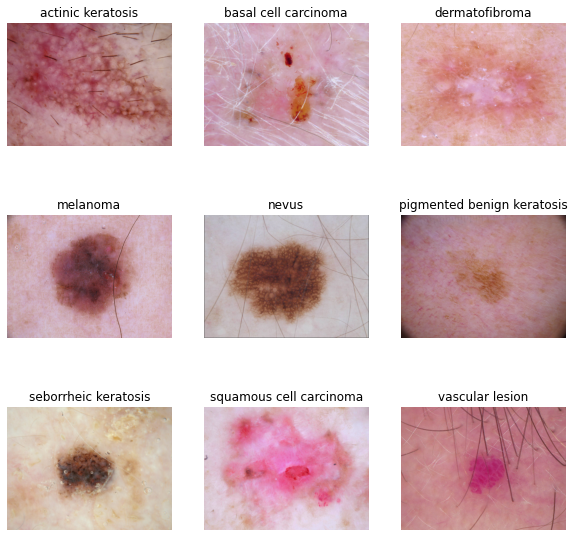

In [46]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


img = []
for i in class_names :
  class_img = list(data_dir_train.glob('*'+ i + '/*'))
  img.append(mpimg.imread(class_img[0]))

plt.figure(figsize=(10,10))

for i in range(len(img)) :
    plt.subplot(3, 3, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[i])
    plt.axis("off")

### Above you can see one image from each class of the dataset.

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [47]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [60]:
# creating a simple sequential model with Rescaling layer, Convolution layer, maxpooling layer and Dense layer

num_classes = len(class_names)

model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)),
                    layers.Conv2D(32,3,padding='same',activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64,3,padding='same',activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(128,3,padding='same',activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Flatten(),
                    layers.Dense(512,activation='relu'),
                    layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [61]:
# compiling the model with most commonly used optimizer : adam, accuracy metric and Sparse Categorical Crossentropy loss
# Note : We can try using other metrics like confusion matrix, F1-Score, ROC AUC

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 128)      

### Train the model

In [63]:
# training the model with 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 85ms/step - loss: 2.2317 - accuracy: 0.2533 - val_loss: 1.7170 - val_accuracy: 0.4116
Epoch 2/20
56/56 [==============================] - 5s 82ms/step - loss: 1.6054 - accuracy: 0.4369 - val_loss: 1.4989 - val_accuracy: 0.4810
Epoch 3/20
56/56 [==============================] - 5s 82ms/step - loss: 1.4287 - accuracy: 0.4978 - val_loss: 1.4091 - val_accuracy: 0.5168
Epoch 4/20
56/56 [==============================] - 5s 82ms/step - loss: 1.3137 - accuracy: 0.5446 - val_loss: 1.5194 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 5s 82ms/step - loss: 1.2452 - accuracy: 0.5541 - val_loss: 1.4246 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 5s 82ms/step - loss: 1.1083 - accuracy: 0.5993 - val_loss: 1.5166 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 5s 82ms/step - loss: 1.0651 - accuracy: 0.6211 - val_loss: 1.4201 - val_accuracy: 0.5436
Epoch 8/20
56

### Visualizing training results

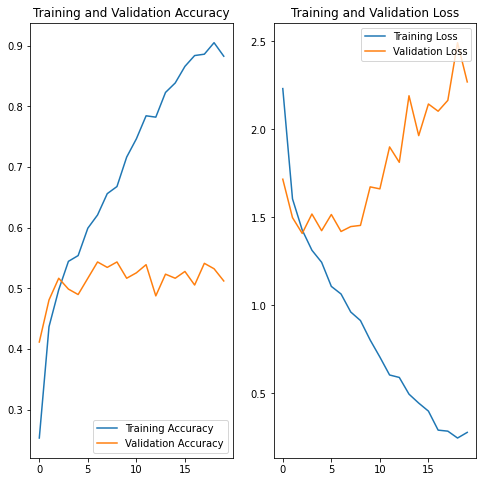

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

We can clearly see in the above graphs :

1. Accuaracy of Training set is increasing significantly with each epoch  (upto 88 percent), and loss for the same is decreasing with the increase in epochs (upto 28 percent).

2. On the other hand, Accuracy and Loss of Validation set is showing very different behaviours. For validation set, accuracy is staying in a very narrow range between 40 to 55 percent. There are lots of spikes between epochs. Validation Loss is increasing overall with each passing epochs with a lots of small ups and downs in between.

3. Finally, we can say that the data is overfitting on the training data and so performing very bad on validation data.

4. Going ahead, we will try introducing more variety of images into our data using augmentation technique.

### Augmentation Technique

In [25]:
# using an data augumentation technique 
# creating a sequential model for augumentation using various operations on our sample images like random horizontal flip, random rotation and random zooming.

data_augmentation = Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

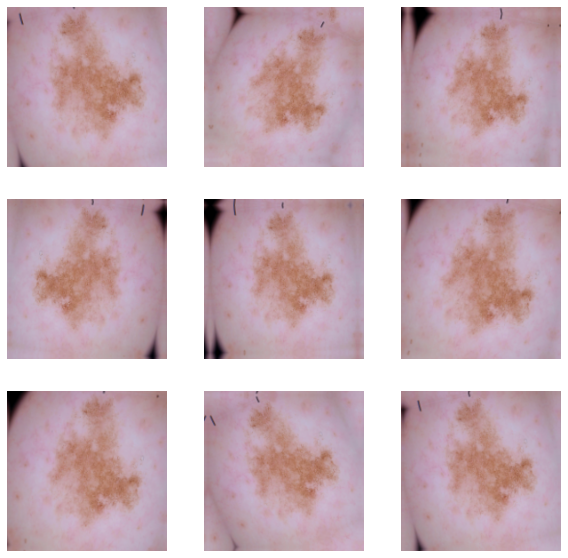

In [79]:
# visualizing how our augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [80]:
# creating another sequential model with Augmentation layer, Scaling layer, Convolution layer, maxpooling layer, dropout layer and Dense layer

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [84]:
# compiling the model with most commonly used optimizer : adam, accuracy metric and Sparse Categorical Crossentropy loss
# Note : We can try using other metrics like confusion matrix, F1-Score, ROC AUC

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [82]:
# summary of the model

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 64)      1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 128)      

### Training the model

In [83]:
# training the model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 17s 239ms/step - loss: 2.5415 - accuracy: 0.1836 - val_loss: 2.0323 - val_accuracy: 0.1969
Epoch 2/20
56/56 [==============================] - 12s 214ms/step - loss: 1.9793 - accuracy: 0.2734 - val_loss: 1.8369 - val_accuracy: 0.3557
Epoch 3/20
56/56 [==============================] - 12s 213ms/step - loss: 1.8060 - accuracy: 0.3555 - val_loss: 1.8233 - val_accuracy: 0.2864
Epoch 4/20
56/56 [==============================] - 12s 213ms/step - loss: 1.6065 - accuracy: 0.4414 - val_loss: 1.4952 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 12s 213ms/step - loss: 1.4963 - accuracy: 0.4788 - val_loss: 1.5107 - val_accuracy: 0.4787
Epoch 6/20
56/56 [==============================] - 12s 214ms/step - loss: 1.4517 - accuracy: 0.4810 - val_loss: 1.4985 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 12s 213ms/step - loss: 1.3816 - accuracy: 0.4983 - val_loss: 1.4143 - val_accuracy: 0.5123

### Visualizing the results

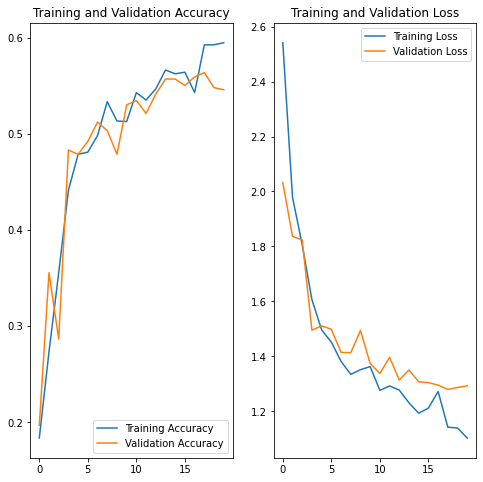

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- So now, after introducing Augmentation and Dropout in our model, we are able to control overfitting and now our model have also improved it's performance on validation set a little. 

- Now, training accuaracy is around 59 percent and valiation accuracy is 54 percent. But this accuracy is not enough for us, we need our model to perform better than this.

- After analysing more on what is the issue and why our model is not able to achieve higher accuracy, I found that there is a class imbalance problem in our dataset, due to which our model is becoming more bias towards classes having high number of images/samples as compare to other classes with less samples.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [138]:
# getting the number of images/samples for each class

sample_count = []

for i in class_names :
  class_img = list(data_dir_train.glob('*'+ i + '/*.jpg'))
  sample_count.append(len(class_img))

class_stats = pd.DataFrame()
class_stats['Class Name'] = pd.Series(class_names)
class_stats['No. of Samples'] = pd.Series(sample_count)

class_stats.sort_values(by=['No. of Samples'],ascending=False)

,Class Name,No. of Samples
5,pigmented benign keratosis,462
3,melanoma,438
1,basal cell carcinoma,376
4,nevus,357
7,squamous cell carcinoma,181
8,vascular lesion,139
0,actinic keratosis,114
2,dermatofibroma,95
6,seborrheic keratosis,77


#### As we can see from the above output, there is huge class imbalance within our dataset.

#### - Which class has the least number of samples?

Ans. Seborrheic Keratosis is the class with least number of samples, 77.

#### - Which classes dominate the data in terms proportionate number of samples?

Ans. Pigmented Benign Keratosis is the class which is dominating in terms of proportionate number of samples, 462.


- Going ahead, we will try to deal with this problem of class imbalance using Augmentor library

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [201]:
# installing Augmentor library

!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [202]:
# writing augmentation code to generate new samples from existing samples.
# here, we have used rotation operation only for augmentation, we can use other operations like zooming, flipping, saturation,etc operation as well.
# We are adding 500 samples per each class to make sure that none of the classes are sparse.

path_to_training_dataset = root_path + '/Train/' 

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/C3 Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3DAEDB4B10>: 100%|██████████| 500/500 [00:23<00:00, 21.51 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/C3 Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3CB063D950>: 100%|██████████| 500/500 [00:23<00:00, 21.05 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/C3 Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3D322A0AD0>: 100%|██████████| 500/500 [00:26<00:00, 18.98 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/C3 Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3D32298B10>: 100%|██████████| 500/500 [01:53<00:00,  4.39 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/C3 Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F3D32279790>: 100%|██████████| 500/500 [01:41<00:00,  4.93 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/C3 Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3CA2BF5C90>: 100%|██████████| 500/500 [00:22<00:00, 22.05 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/C3 Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F3D321E9F50>: 100%|██████████| 500/500 [00:55<00:00,  9.04 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/C3 Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3D34616610>: 100%|██████████| 500/500 [00:23<00:00, 21.09 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/C3 Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3D31A88C10>: 100%|██████████| 500/500 [00:23<00:00, 21.22 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [16]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets compare the distribution of samples/images among classes before augmention and after augmention

#### Before adding Augmented images

In [17]:
sample_count = []

for i in class_names :
  class_img = list(data_dir_train.glob('*'+ i + '/*.jpg'))
  sample_count.append(len(class_img))

class_stats = pd.DataFrame()
class_stats['Class Name'] = pd.Series(class_names)
class_stats['No. of Samples'] = pd.Series(sample_count)

class_stats.sort_values(by=['No. of Samples'],ascending=False)

,Class Name,No. of Samples
5,pigmented benign keratosis,462
3,melanoma,438
1,basal cell carcinoma,376
4,nevus,357
7,squamous cell carcinoma,181
8,vascular lesion,139
0,actinic keratosis,114
2,dermatofibroma,95
6,seborrheic keratosis,77


#### No. of Augmented images for each class

In [18]:
sample_count = []

for i in class_names :
  class_img_output = list(data_dir_train.glob('*'+ i + '/output/*.jpg'))
  sample_count.append(len(class_img_output))

class_stats = pd.DataFrame()
class_stats['Class Name'] = pd.Series(class_names)
class_stats['No. of Samples'] = pd.Series(sample_count)

class_stats.sort_values(by=['No. of Samples'],ascending=False)

,Class Name,No. of Samples
0,actinic keratosis,500
1,basal cell carcinoma,500
2,dermatofibroma,500
3,melanoma,500
4,nevus,500
5,pigmented benign keratosis,500
6,seborrheic keratosis,500
7,squamous cell carcinoma,500
8,vascular lesion,500


#### After adding Augmented images to our original dataset

In [19]:
sample_count = []

for i in class_names :
  class_img = list(data_dir_train.glob('*'+ i + '/*.jpg'))
  class_img_output = list(data_dir_train.glob('*'+ i + '/output/*.jpg'))
  sample_count.append(len(class_img) + len(class_img_output))

class_stats = pd.DataFrame()
class_stats['Class Name'] = pd.Series(class_names)
class_stats['No. of Samples'] = pd.Series(sample_count)

class_stats.sort_values(by=['No. of Samples'],ascending=False)

,Class Name,No. of Samples
5,pigmented benign keratosis,962
3,melanoma,938
1,basal cell carcinoma,876
4,nevus,857
7,squamous cell carcinoma,681
8,vascular lesion,639
0,actinic keratosis,614
2,dermatofibroma,595
6,seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. Now we can clearly see there is a good balance of no. of samples among various classes.

#### **Todo**: Train the model on the data created using Augmentor

In [20]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [21]:
data_dir_train= data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [22]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Creating the model (with Batch Normalization)

In [27]:
# creating another sequential model with Augmentation Layer, Scaling layer, Convolution layer, Batch Normalization layer, maxpooling layer, dropout layer and Dense layer

num_classes = 9

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [28]:
# compiling the model with most commonly used optimizer : adam, accuracy metric and Sparse Categorical Crossentropy loss
# Note : We can try using other metrics like confusion matrix, F1-Score, ROC AUC

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [29]:
# training with 30 epochs

epochs = 12

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/12
169/169 [==============================] - 64s 305ms/step - loss: 1.6567 - accuracy: 0.4021 - val_loss: 4.2584 - val_accuracy: 0.1403
Epoch 2/12
169/169 [==============================] - 50s 291ms/step - loss: 1.4524 - accuracy: 0.4529 - val_loss: 3.1014 - val_accuracy: 0.2175
Epoch 3/12
169/169 [==============================] - 50s 287ms/step - loss: 1.2828 - accuracy: 0.5148 - val_loss: 1.8741 - val_accuracy: 0.3252
Epoch 4/12
169/169 [==============================] - 51s 291ms/step - loss: 1.2122 - accuracy: 0.5497 - val_loss: 1.6296 - val_accuracy: 0.4425
Epoch 5/12
169/169 [==============================] - 50s 290ms/step - loss: 1.1104 - accuracy: 0.5762 - val_loss: 1.5601 - val_accuracy: 0.4543
Epoch 6/12
169/169 [==============================] - 50s 288ms/step - loss: 1.1444 - accuracy: 0.5721 - val_loss: 1.3870 - val_accuracy: 0.4907
Epoch 7/12
169/169 [==============================] - 50s 289ms/step - loss: 1.0988 - accuracy: 0.5912 - val_loss: 1.7466 - val_ac

- Note : I have run the model for only 12 epochs, due to slow system and lack of time, but earlier I have run the model for 30 epochs, training output of the same is pasted in below cell. 
- Finally, we have got good results on both training and validation data.
- We can consider this model for prediction on Test data.

- Earlier, I have tried running the model with 30 epochs as well, kindly find the result of that training in the below cell.



```
Epoch 1/30
169/169 [==============================] - 53s 279ms/step - loss: 2.5522 - accuracy: 0.3812 - val_loss: 1.8963 - val_accuracy: 0.1636
Epoch 2/30
169/169 [==============================] - 47s 273ms/step - loss: 1.8045 - accuracy: 0.4270 - val_loss: 1.5901 - val_accuracy: 0.2308
Epoch 3/30
169/169 [==============================] - 47s 268ms/step - loss: 1.5609 - accuracy: 0.4337 - val_loss: 1.4437 - val_accuracy: 0.3410
Epoch 4/30
169/169 [==============================] - 47s 270ms/step - loss: 1.4504 - accuracy: 0.4527 - val_loss: 1.4078 - val_accuracy: 0.4514
Epoch 5/30
169/169 [==============================] - 47s 269ms/step - loss: 1.3568 - accuracy: 0.4777 - val_loss: 1.3105 - val_accuracy: 0.5085
Epoch 6/30
169/169 [==============================] - 47s 271ms/step - loss: 1.3254 - accuracy: 0.4981 - val_loss: 1.3965 - val_accuracy: 0.4707
Epoch 7/30
169/169 [==============================] - 47s 268ms/step - loss: 1.2522 - accuracy: 0.5237 - val_loss: 1.1952 - val_accuracy: 0.5264
Epoch 8/30
169/169 [==============================] - 46s 266ms/step - loss: 1.1700 - accuracy: 0.5436 - val_loss: 1.1077 - val_accuracy: 0.5872
Epoch 9/30
169/169 [==============================] - 46s 265ms/step - loss: 1.1105 - accuracy: 0.5823 - val_loss: 1.1280 - val_accuracy: 0.5687
Epoch 10/30
169/169 [==============================] - 46s 265ms/step - loss: 1.0686 - accuracy: 0.5918 - val_loss: 1.0617 - val_accuracy: 0.6377
Epoch 11/30
169/169 [==============================] - 46s 265ms/step - loss: 1.0015 - accuracy: 0.6141 - val_loss: 1.0029 - val_accuracy: 0.6540
Epoch 12/30
169/169 [==============================] - 47s 269ms/step - loss: 0.9755 - accuracy: 0.6350 - val_loss: 0.9867 - val_accuracy: 0.6496
Epoch 13/30
169/169 [==============================] - 46s 266ms/step - loss: 0.8770 - accuracy: 0.6647 - val_loss: 1.0137 - val_accuracy: 0.6437
Epoch 14/30
169/169 [==============================] - 47s 269ms/step - loss: 0.8253 - accuracy: 0.6818 - val_loss: 0.8117 - val_accuracy: 0.7261
Epoch 15/30
169/169 [==============================] - 47s 272ms/step - loss: 0.7299 - accuracy: 0.7277 - val_loss: 0.8244 - val_accuracy: 0.7186
Epoch 16/30
169/169 [==============================] - 48s 275ms/step - loss: 0.7211 - accuracy: 0.7274 - val_loss: 0.9423 - val_accuracy: 0.6726
Epoch 17/30
169/169 [==============================] - 47s 272ms/step - loss: 0.6960 - accuracy: 0.7346 - val_loss: 0.7569 - val_accuracy: 0.7498
Epoch 18/30
169/169 [==============================] - 47s 273ms/step - loss: 0.6133 - accuracy: 0.7669 - val_loss: 0.8290 - val_accuracy: 0.7476
Epoch 19/30
169/169 [==============================] - 47s 273ms/step - loss: 0.6285 - accuracy: 0.7606 - val_loss: 0.7497 - val_accuracy: 0.7654
Epoch 20/30
169/169 [==============================] - 48s 275ms/step - loss: 0.5424 - accuracy: 0.7960 - val_loss: 0.7327 - val_accuracy: 0.7706
Epoch 21/30
169/169 [==============================] - 48s 276ms/step - loss: 0.4976 - accuracy: 0.8123 - val_loss: 0.9164 - val_accuracy: 0.7112
Epoch 22/30
169/169 [==============================] - 47s 273ms/step - loss: 0.5043 - accuracy: 0.8071 - val_loss: 0.6375 - val_accuracy: 0.8122
Epoch 23/30
169/169 [==============================] - 48s 276ms/step - loss: 0.4499 - accuracy: 0.8272 - val_loss: 0.7461 - val_accuracy: 0.7832
Epoch 24/30
169/169 [==============================] - 48s 277ms/step - loss: 0.4848 - accuracy: 0.8195 - val_loss: 0.7070 - val_accuracy: 0.7914
Epoch 25/30
169/169 [==============================] - 48s 278ms/step - loss: 0.4195 - accuracy: 0.8392 - val_loss: 0.6465 - val_accuracy: 0.8151
Epoch 26/30
169/169 [==============================] - 48s 278ms/step - loss: 0.3785 - accuracy: 0.8507 - val_loss: 0.6821 - val_accuracy: 0.8322
Epoch 27/30
169/169 [==============================] - 48s 274ms/step - loss: 0.3703 - accuracy: 0.8592 - val_loss: 0.5885 - val_accuracy: 0.8478
Epoch 28/30
169/169 [==============================] - 47s 271ms/step - loss: 0.3855 - accuracy: 0.8589 - val_loss: 0.6725 - val_accuracy: 0.8166
Epoch 29/30
169/169 [==============================] - 47s 272ms/step - loss: 0.3718 - accuracy: 0.8544 - val_loss: 0.6035 - val_accuracy: 0.8330
Epoch 30/30
169/169 [==============================] - 47s 270ms/step - loss: 0.3269 - accuracy: 0.8713 - val_loss: 0.6839 - val_accuracy: 0.8471
```



#### **Todo:**  Visualize the model results

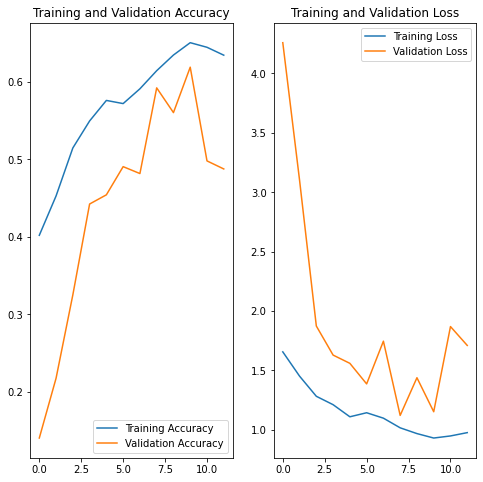

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- Yes, so after using augmentation technique to deal with class imbalance problem and overfitting problem, finally we are able to get a pretty nice model with 87 percent accuracy on training data and 84 percent on the validation data.

- Now let's see how our final model works on Test data.

In [33]:
# importing test data

data_dir_test = data_dir_test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [34]:
#  evaluating our final model on test data 

model.evaluate(test_ds)

4/4 [==============================] - 5s 416ms/step - loss: 4.1973 - accuracy: 0.3814


[4.197340965270996, 0.3813559412956238]

Pretty Good !

- Our final model is able to classify with around 40 percent accuracy on test data, so there is still chance of iproving the model further.
- Below is the confusion matrix

In [35]:
# generating confusion matrix

from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_ds)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

confusion_matrix(predicted_categories, true_categories)

array([[1, 1, 1, 0, 1, 0, 0, 0, 1],
       [1, 4, 3, 7, 6, 3, 0, 3, 0],
       [1, 0, 0, 0, 1, 0, 2, 1, 0],
       [2, 5, 3, 1, 2, 3, 0, 1, 0],
       [5, 5, 5, 6, 3, 8, 1, 6, 1],
       [1, 0, 1, 2, 1, 2, 0, 2, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0],
       [4, 1, 2, 0, 1, 0, 0, 1, 1],
       [1, 0, 0, 0, 1, 0, 0, 1, 0]])

In [36]:
# generating classification report which shows F1-Score, precision, recall, etc metrics

from sklearn.metrics import classification_report

print(classification_report(predicted_categories, true_categories))

              precision    recall  f1-score   support

           0       0.06      0.20      0.10         5
           1       0.25      0.15      0.19        27
           2       0.00      0.00      0.00         5
           3       0.06      0.06      0.06        17
           4       0.19      0.07      0.11        40
           5       0.12      0.22      0.16         9
           6       0.00      0.00      0.00         2
           7       0.06      0.10      0.08        10
           8       0.00      0.00      0.00         3

    accuracy                           0.10       118
   macro avg       0.08      0.09      0.08       118
weighted avg       0.15      0.10      0.11       118

